ENVIRON

In [1]:
from math import ceil
import os
import sys
import time
from datetime import datetime
sys.path.insert(0, './boruvka-superpixel/pybuild')

In [36]:
from tqdm import tqdm, trange
from pandarallel import pandarallel
import swifter
from swifter import set_defaults
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [3]:
from PIL import Image
from PIL import ImageFilter
import skimage as ski
from skimage.segmentation import slic
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from rdp import rdp
import boruvka_superpixel

In [4]:
import networkx as nx

In [5]:
from IPython.display import clear_output
import ipywidgets

In [6]:
from itertools import combinations

In [8]:
tqdm.pandas()
pandarallel.initialize(
    progress_bar = False,       # True,
    nb_workers = 8,
    verbose = 2,
    use_memory_fs = None,
)
swifter.set_defaults(
    npartitions = 8,
    progress_bar = True,
    progress_bar_desc = 'Working...'
)
UNIT = 1000
NUM_SUPERPIXEL = 25

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


DATASET

In [9]:
filenames = []
labels = []

In [10]:
select_df = pd.read_csv('./select.csv')

In [11]:
select_df['directory'][:5].values

array(['n01443537', 'n01514668', 'n01532829', 'n01614925', 'n01631663'],
      dtype=object)

In [12]:
for foldername in tqdm(select_df['directory'][:5].values):            # os.listdir(f'./ImageNet/train')[:10]):
    for filename in os.listdir(f'./ImageNet/train/{foldername}'):
        filenames.append(f'./ImageNet/train/{foldername}/{filename}')
        labels.append(foldername)
        break

100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


In [13]:
df = pd.DataFrame(columns = ['filename', 'label'])

In [14]:
num_processed = 0           # len(os.listdir('./converted_75/train'))

CONVERSION UNDER CHUNKING

In [15]:
def rgb2lab(image):
    return ski.color.rgb2lab(image)

In [16]:
def get_slic(img, num):
    return slic(img, num) - 1

In [17]:
def get_boruvka(img, num):
    img_edge = np.zeros((img.shape[:2]), dtype=img.dtype)
    bosupix = boruvka_superpixel.BoruvkaSuperpixel()
    bosupix.build_2d(img, img_edge)
    return bosupix.label(num)

In [18]:
def get_networkx(image, format, algo):
    assert format in ['rgb', 'lab']
    assert algo in ['slic', 'boruvka']
    
    if image[f'{algo}_{format}'].max() == 0:
        return nx.Graph()

    return nx.Graph(ski.graph.rag_mean_color(image[format], image[f'{algo}_{format}']))

In [19]:
def get_approxed_polygon(label_img):
    polygons = []
    
    for index in range(label_img.max()):
        mask = Image.fromarray((label_img == index).astype(np.uint8) * 255)
        contour = mask.filter(ImageFilter.CONTOUR)
        points = find_contours((label_img == index).astype(np.uint8), 0)[0]
        points = subdivide_polygon(points, degree = 2, preserve_ends = True)
        points = approximate_polygon(points, tolerance = 8)
        polygons.append(points)\
    
    return polygons

In [20]:
def get_local_graphs(coordinates):
    graphs = []

    for coordinate in coordinates:
        mean = coordinate.mean(axis = 0)
        G = nx.Graph()
        for index, coor in enumerate(coordinate):
            coor = coor - mean
            G.add_node(index, coor = coor)
        for index in range(G.number_of_nodes()):
            u = G.nodes()[index]
            v = G.nodes()[(index + 1) % G.number_of_nodes()]
            G.add_edge(index, (index + 1) % G.number_of_nodes(), weight = np.linalg.norm(u['coor'] - v['coor']))
        graphs.append(G)

    return graphs

In [22]:
for chunk_id in trange(ceil(len(filenames) / UNIT)):
    if chunk_id < num_processed:
        continue

    df25 = pd.DataFrame(columns = ['filename', 'label'])
    chunk_files = filenames[chunk_id * UNIT:(chunk_id + 1) * UNIT]
    chunk_labels = labels[chunk_id * UNIT:(chunk_id + 1) * UNIT]
    
    df25['filename'] = chunk_files
    df25['label'] = chunk_labels
    
    # RGB and LAB Image
    df25['rgb'] = df25['filename'].parallel_apply(lambda x : np.array(Image.open(x).convert('RGB').resize((128, 128))))
    df25['lab'] = df25['rgb'].parallel_apply(ski.color.rgb2lab)
    
    # SLIC and BORUVKA superpixels
    df25['slic_rgb'] = df25['rgb'].parallel_apply(lambda x : get_slic(x, 25))
    df25['slic_lab'] = df25['lab'].parallel_apply(lambda x : get_slic(x, 25))
    df25['boruvka_rgb'] = df25['rgb'].parallel_apply(lambda x : get_boruvka(x, 25))
    df25['boruvka_lab'] = df25['lab'].parallel_apply(lambda x : get_boruvka(x, 25))
    
    # Num of superpixels
    df25['slic_rgb_count'] = df25['slic_rgb'].parallel_apply(lambda x : x.max())
    df25['slic_lab_count'] = df25['slic_lab'].parallel_apply(lambda x : x.max())
    df25['boruvka_rgb_count'] = df25['boruvka_rgb'].parallel_apply(lambda x : x.max())
    df25['boruvka_lab_count'] = df25['boruvka_lab'].parallel_apply(lambda x : x.max())

    # Global Graphs
    df25['slic_rgb_global_graph'] = df25.parallel_apply(lambda x : get_networkx(x, 'rgb', 'slic'), axis = 1)
    df25['slic_lab_global_graph'] = df25.parallel_apply(lambda x : get_networkx(x, 'lab', 'slic'), axis = 1)
    df25['boruvka_rgb_global_graph'] = df25.parallel_apply(lambda x : get_networkx(x, 'rgb', 'boruvka'), axis = 1)
    df25['boruvka_lab_global_graph'] = df25.parallel_apply(lambda x : get_networkx(x, 'lab', 'boruvka'), axis = 1)
    
    # Local coordinates
    df25['slic_rgb_local_coor'] = df25['slic_rgb'].parallel_apply(get_approxed_polygon)
    df25['slic_lab_local_coor'] = df25['slic_lab'].parallel_apply(get_approxed_polygon)
    df25['boruvka_rgb_local_coor'] = df25['boruvka_rgb'].parallel_apply(get_approxed_polygon)
    df25['boruvka_lab_local_coor'] = df25['boruvka_lab'].parallel_apply(get_approxed_polygon)
    
    # Local Graphs
    df25['slic_rgb_local_graph'] = df25['slic_rgb_local_coor'].parallel_apply(get_local_graphs)
    df25['slic_lab_local_graph'] = df25['slic_lab_local_coor'].parallel_apply(get_local_graphs)
    df25['boruvka_rgb_local_graph'] = df25['boruvka_rgb_local_coor'].parallel_apply(get_local_graphs)
    df25['boruvka_lab_local_graph'] = df25['boruvka_lab_local_coor'].parallel_apply(get_local_graphs)

    # df25.to_pickle(f'./converted/train/data{chunk_id:04d}.pkl')

100%|██████████| 1/1 [00:11<00:00, 11.69s/it]


In [23]:
for chunk_id in trange(ceil(len(filenames) / UNIT)):
    if chunk_id < num_processed:
        continue

    df75 = pd.DataFrame(columns = ['filename', 'label'])
    chunk_files = filenames[chunk_id * UNIT:(chunk_id + 1) * UNIT]
    chunk_labels = labels[chunk_id * UNIT:(chunk_id + 1) * UNIT]
    
    df75['filename'] = chunk_files
    df75['label'] = chunk_labels
    
    # RGB and LAB Image
    df75['rgb'] = df75['filename'].parallel_apply(lambda x : np.array(Image.open(x).convert('RGB').resize((128, 128))))
    df75['lab'] = df75['rgb'].parallel_apply(ski.color.rgb2lab)
    
    # SLIC and BORUVKA superpixels
    df75['slic_rgb'] = df75['rgb'].parallel_apply(lambda x : get_slic(x, 75))
    df75['slic_lab'] = df75['lab'].parallel_apply(lambda x : get_slic(x, 75))
    df75['boruvka_rgb'] = df75['rgb'].parallel_apply(lambda x : get_boruvka(x, 75))
    df75['boruvka_lab'] = df75['lab'].parallel_apply(lambda x : get_boruvka(x, 75))
    
    # Num of superpixels
    df75['slic_rgb_count'] = df75['slic_rgb'].parallel_apply(lambda x : x.max())
    df75['slic_lab_count'] = df75['slic_lab'].parallel_apply(lambda x : x.max())
    df75['boruvka_rgb_count'] = df75['boruvka_rgb'].parallel_apply(lambda x : x.max())
    df75['boruvka_lab_count'] = df75['boruvka_lab'].parallel_apply(lambda x : x.max())

    # Global Graphs
    df75['slic_rgb_global_graph'] = df75.parallel_apply(lambda x : get_networkx(x, 'rgb', 'slic'), axis = 1)
    df75['slic_lab_global_graph'] = df75.parallel_apply(lambda x : get_networkx(x, 'lab', 'slic'), axis = 1)
    df75['boruvka_rgb_global_graph'] = df75.parallel_apply(lambda x : get_networkx(x, 'rgb', 'boruvka'), axis = 1)
    df75['boruvka_lab_global_graph'] = df75.parallel_apply(lambda x : get_networkx(x, 'lab', 'boruvka'), axis = 1)
    
    # Local coordinates
    df75['slic_rgb_local_coor'] = df75['slic_rgb'].parallel_apply(get_approxed_polygon)
    df75['slic_lab_local_coor'] = df75['slic_lab'].parallel_apply(get_approxed_polygon)
    df75['boruvka_rgb_local_coor'] = df75['boruvka_rgb'].parallel_apply(get_approxed_polygon)
    df75['boruvka_lab_local_coor'] = df75['boruvka_lab'].parallel_apply(get_approxed_polygon)
    
    # Local Graphs
    df75['slic_rgb_local_graph'] = df75['slic_rgb_local_coor'].parallel_apply(get_local_graphs)
    df75['slic_lab_local_graph'] = df75['slic_lab_local_coor'].parallel_apply(get_local_graphs)
    df75['boruvka_rgb_local_graph'] = df75['boruvka_rgb_local_coor'].parallel_apply(get_local_graphs)
    df75['boruvka_lab_local_graph'] = df75['boruvka_lab_local_coor'].parallel_apply(get_local_graphs)

    # df75.to_pickle(f'./converted/train/data{chunk_id:04d}.pkl')

100%|██████████| 1/1 [00:12<00:00, 12.53s/it]


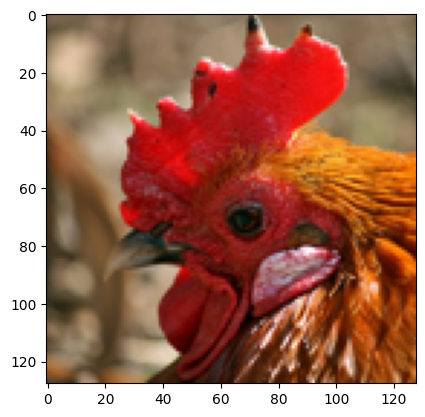

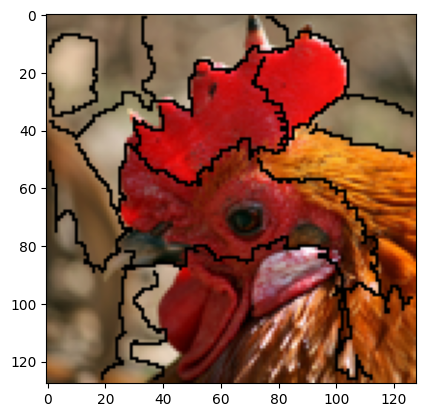

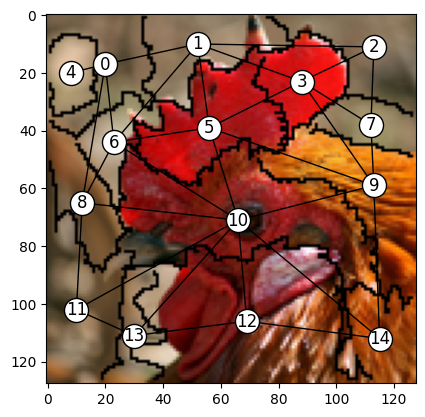

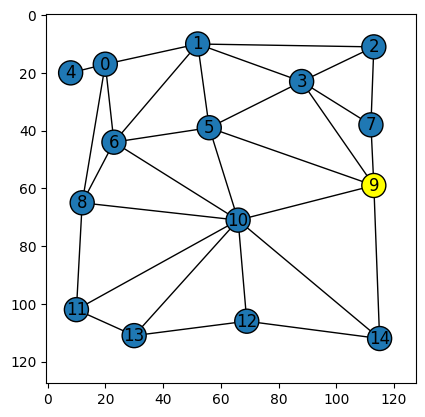

In [75]:
index = 1

# Draw Original Image
plt.imshow(df25['rgb'][index])
plt.savefig(f'./present/original_image{index}.png')
plt.show()

# Draw Superpixel Image
contour = np.array(Image.fromarray(df25['slic_rgb'][index].astype(np.uint8)).filter(ImageFilter.CONTOUR))
contour[0, :] = 255
contour[-1, :] = 255
contour[:, 0] = 255
contour[:, -1] = 255
contour = (contour == 255).astype(np.uint8) * 255

plt.imshow(np.minimum(df25['rgb'][index], ((contour == 255).astype(np.uint8) * 255)[:, :, np.newaxis]))
plt.savefig(f'./present/supix25_image{index}.png')
plt.show()

# Draw Superpixel Image
G = df25['slic_rgb_global_graph'][index]
centroids = [np.median(np.argwhere(df25['slic_rgb'][index] == i), axis = 0) for i in range(df25['slic_rgb_count'][index] + 1)]
layout = {index: (centroid[1], centroid[0]) for index, centroid in enumerate(centroids)}

fig = plt.imshow(np.minimum(df25['rgb'][index], ((contour == 255).astype(np.uint8) * 255)[:, :, np.newaxis]))
nx.draw_networkx(G, pos = layout, node_color = '#ffffff', edgecolors = '#000000', ax = fig.axes)
fig.axes.set_axis_on()
fig.axes.tick_params(left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig(f'./present/supix25_graph_image{index}.png')
plt.show()

# Draw Graph Only
fig = plt.imshow(np.ones(df25['rgb'][index].shape))
nx.draw_networkx(G, pos = layout, node_color = ['#1f78b4' if index != 9 else '#ffff00' for index in range(G.number_of_nodes())], edgecolors = '#000000')
fig.axes.set_axis_on()
fig.axes.set_xticks(range(0, 128, 20))
fig.axes.set_yticks(range(0, 128, 20))
fig.axes.tick_params(left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig(f'./present/supix25_graph_only_image{index}.png')
plt.show()

# # # Draw Superpixel Image
# contour = np.array(Image.fromarray(df75['slic_rgb'][index].astype(np.uint8)).filter(ImageFilter.CONTOUR))
# contour[0, :] = 255
# contour[-1, :] = 255
# contour[:, 0] = 255
# contour[:, -1] = 255
# contour = (contour == 255).astype(np.uint8) * 255

# plt.imshow(np.minimum(df75['rgb'][index], ((contour == 255).astype(np.uint8) * 255)[:, :, np.newaxis]))
# plt.savefig(f'./present/supix75_image{index}.png')
# plt.show()

# # Draw Superpixel Image
# G = df75['slic_rgb_global_graph'][index]
# centroids = [np.median(np.argwhere(df75['slic_rgb'][index] == i), axis = 0) for i in range(df75['slic_rgb_count'][index] + 1)]
# layout = {index: (centroid[1], centroid[0]) for index, centroid in enumerate(centroids)}

# fig = plt.imshow(np.minimum(df75['rgb'][index], ((contour == 255).astype(np.uint8) * 255)[:, :, np.newaxis]))
# nx.draw_networkx(G, pos = layout, node_color = '#ffffff', edgecolors = '#000000', ax = fig.axes)
# fig.axes.set_axis_on()
# fig.axes.set_xticks(range(0, 128, 20))
# fig.axes.set_yticks(range(0, 128, 20))
# fig.axes.set_xlim(0, 128)
# fig.axes.set_ylim(128, 0)
# fig.axes.tick_params(left = True, bottom = True, labelleft = True, labelbottom = True)
# plt.savefig(f'./present/supix75_graph_image{index}.png')
# plt.show()

# # Draw Graph Only
# fig = plt.imshow(np.ones(df75['rgb'][index].shape))
# nx.draw_networkx(G, pos = layout)
# fig.axes.set_axis_on()
# fig.axes.set_xlim(0, 128)
# fig.axes.set_ylim(128, 0)
# fig.axes.tick_params(left = True, bottom = True, labelleft = True, labelbottom = True)
# plt.savefig(f'./present/supix75_graph_only_image{index}.png')
# plt.show()

In [61]:
image = df25['rgb'][1]
mask = df25['slic_rgb'][1] == 9
mask = np.expand_dims(mask, axis = -1)
masked_image = image * mask
masked_image = masked_image.reshape(-1, 3) / 255

In [58]:
masked_image

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

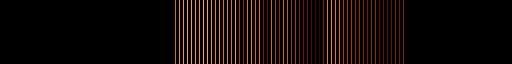

In [67]:
LinearSegmentedColormap.from_list('Color', masked_image, N = 1024)